In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window

## **Exploratory Data Anlysis**

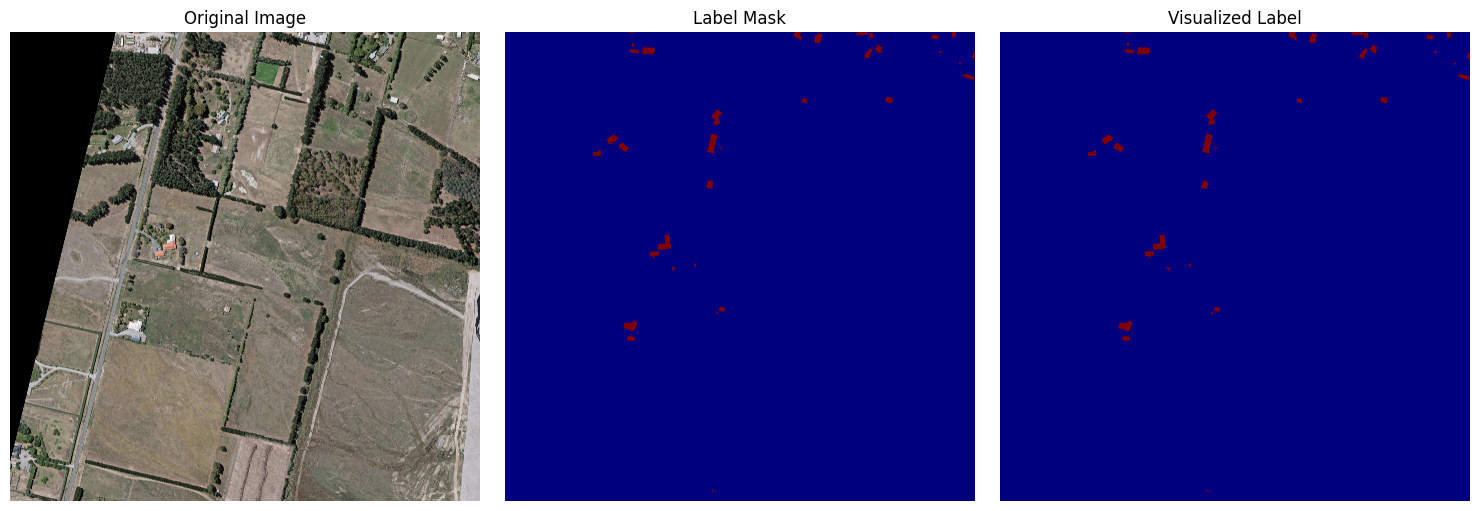

In [2]:
img_id = 10

with rasterio.open(f"data\\train\\image\\christchurch_{img_id}.tif") as src:
    img = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}.tif") as src:
    label = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}_vis.tif") as src:
    label_vis = src.read()
    

# Create figure
plt.figure(figsize=(15, 5))

# Plot 1: Original Image (RGB)
plt.subplot(1, 3, 1)
if img.shape[0] == 3:  # If RGB image
    plt.imshow(img.transpose(1, 2, 0))  # Convert from (C,H,W) to (H,W,C)
else:  # If single channel
    plt.imshow(img[0], cmap='gray')  # Show first band
plt.title("Original Image")
plt.axis('off')

# Plot 2: Label Mask
plt.subplot(1, 3, 2)
if len(label.shape) == 3:
    plt.imshow(label[0], cmap='jet')  # Show first band of label
else:
    plt.imshow(label, cmap='jet')
plt.title("Label Mask")
plt.axis('off')

# Plot 3: Visualized Label
plt.subplot(1, 3, 3)
if label_vis.shape[0] == 3:  # If RGB
    plt.imshow(label_vis.transpose(1, 2, 0))
else:  # If single channel
    plt.imshow(label_vis[0], cmap='jet')
plt.title("Visualized Label")
plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
print(img.shape, label.shape, label_vis.shape)

(3, 10000, 10000) (1, 10000, 10000) (1, 10000, 10000)


In [4]:
img.min(), img.max()

(np.uint8(0), np.uint8(255))

In [ ]:
import os


857

## **Patch Process Test**

In [5]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from src.preprocess import MultiFileRoofDataset
from torchvision import transforms
import torch.nn.functional as F


In [46]:

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = MultiFileRoofDataset(
    img_dir="data/train/image",
    mask_dir="data/train/label",
    patch_size=512,
    stride=256,
    augment=True,
    subset_size=200
)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

val_data = MultiFileRoofDataset(
    img_dir="data/val/image",
    mask_dir="data/val/label",
    patch_size=512,
    stride=256,
    augment=True,
    subset_size=40
)
train_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=16,
    shuffle=True,
    num_workers=4
)


In [47]:
INPUT_SIZE = 512

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(CNN, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # (1, 16, 512, 512)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (1, 32, 512, 512)
        self.pool = nn.MaxPool2d(2, 2)  # (1, 32, 256, 256)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Down to 128x128

        # Bottleneck
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Up to 256x256
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # Up to 512x512
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        # Output Layer (Same size as input)
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))

        x3 = F.relu(self.conv3(x2))
        x4 = self.pool2(F.relu(x3))

        # Bottleneck
        x5 = F.relu(self.conv4(x4))

        # Decoding
        x6 = F.relu(self.upconv1(x5))  # Up to 256x256
        x6 = F.relu(self.conv5(x6))

        x7 = F.relu(self.upconv2(x6))  # Up to 512x512
        x7 = F.relu(self.conv6(x7))

        # Final Output (Mask)
        x_out = torch.sigmoid(self.final_conv(x7))  # Binary mask output
        return x_out



In [49]:
from torchsummary import summary

# Example usage
model = CNN()
print(f"Summary: {summary(model, input_size=(3,512,512))}")
sample_input = torch.randn(1, 3, 512, 512)  # Batch size 1, RGB image
output = model(sample_input)
print(output.shape)  # Should be (1, 1, 512, 512)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
            Conv2d-2         [-1, 32, 512, 512]           4,640
         MaxPool2d-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          18,496
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
   ConvTranspose2d-7         [-1, 64, 256, 256]          32,832
            Conv2d-8         [-1, 32, 256, 256]          18,464
   ConvTranspose2d-9         [-1, 16, 512, 512]           2,064
           Conv2d-10          [-1, 8, 512, 512]           1,160
           Conv2d-11          [-1, 1, 512, 512]               9
Total params: 151,969
Trainable params: 151,969
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/

In [52]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-2, device="cpu"):
    """
    Train the CNN model for image segmentation.

    Parameters:
    - model: PyTorch model (CNN)
    - train_loader: DataLoader for training set
    - val_loader: DataLoader for validation set
    - num_epochs: Number of epochs
    - learning_rate: Initial learning rate
    - device: "cuda" or "cpu"

    Returns:
    - Trained model
    """
    # Move model to GPU/CPU
    model.to(device)
    
    # Loss function: Binary Cross-Entropy for binary segmentation
    criterion = nn.BCELoss()  # Use nn.CrossEntropyLoss() for multi-class masks

    # Optimizer: Adam with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning Rate Scheduler (optional)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0
        # Initialize tqdm progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)  # Move to GPU

            optimizer.zero_grad()  # Reset gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Compute loss

            loss.backward()  # Backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
            
            # Update tqdm description with current loss
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Adjust learning rate
        scheduler.step()

        # Print epoch stats
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

        # Validation (Optional)
        if val_loader:
            validate_model(model, val_loader, criterion, device)

    return model

@torch.no_grad()
def validate_model(model, val_loader, criterion, device="cpu"):
    """
    Validate model on the validation dataset.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    

@torch.no_grad()
def predict(model, input_data, device="cpu", threshold=None):
    """
    Make predictions using the trained model.

    Parameters:
    - model: Trained PyTorch model
    - input_data: Can be one of:
        * Single image (3D tensor [C, H, W])
        * Batch of images (4D tensor [B, C, H, W])
        * PIL Image (will be converted to tensor)
        * numpy array (will be converted to tensor)
    - device: "cuda" or "cpu"
    - threshold: If provided (0-1), probabilities will be thresholded to create binary masks

    Returns:
    - Predicted masks as numpy array with same shape as input (without batch dimension)
    """
    import numpy as np
    from PIL import Image
    import torchvision.transforms as transforms
    
    # Store original input type to return consistent output
    input_type = type(input_data)
    
    # Convert different input types to tensor
    if isinstance(input_data, (Image.Image, np.ndarray)):
        transform = transforms.ToTensor()
        input_data = transform(input_data).unsqueeze(0)  # Add batch dimension
    elif isinstance(input_data, torch.Tensor):
        if input_data.dim() == 3:  # Single image [C,H,W]
            input_data = input_data.unsqueeze(0)  # Add batch dimension
    else:
        raise ValueError("Input must be PIL Image, numpy array, or torch tensor")
    
    # Move to device and make prediction
    model.eval()
    input_data = input_data.to(device)
    output = model(input_data)
    
    # Apply threshold if provided
    if threshold is not None:
        output = (output > threshold).float()
    
    # Convert to numpy and remove batch dimension if input didn't have one
    output = output.squeeze().cpu().numpy()  # Removes batch dim if batch_size=1
    
    # If input was PIL or single image numpy array, ensure we return same shape
    if input_type in (Image.Image, np.ndarray) and output.ndim == 3:
        output = output.squeeze(0)  # Remove channel dim if it's 1
    
    return output


In [53]:
# Assuming you have a DataLoader for training & validation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Create model instance
model = CNN()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-3)


Epoch [1/50]: 100%|██████████| 7/7 [00:38<00:00,  5.43s/it, loss=0.6224]


Epoch [1/50], Loss: 0.6430
Validation Loss: 0.6305


Epoch [2/50]: 100%|██████████| 7/7 [00:39<00:00,  5.63s/it, loss=0.4306]


Epoch [2/50], Loss: 0.5636
Validation Loss: 0.4048


Epoch [3/50]: 100%|██████████| 7/7 [00:41<00:00,  5.89s/it, loss=0.4925]


Epoch [3/50], Loss: 0.3826
Validation Loss: 0.3680


Epoch [4/50]: 100%|██████████| 7/7 [00:39<00:00,  5.62s/it, loss=0.4438]


Epoch [4/50], Loss: 0.3426
Validation Loss: 0.3440


Epoch [5/50]: 100%|██████████| 7/7 [00:39<00:00,  5.67s/it, loss=0.2216]


Epoch [5/50], Loss: 0.3036
Validation Loss: 0.3263


Epoch [6/50]: 100%|██████████| 7/7 [00:39<00:00,  5.65s/it, loss=0.1124]


Epoch [6/50], Loss: 0.2787
Validation Loss: 0.3042


Epoch [7/50]: 100%|██████████| 7/7 [00:39<00:00,  5.67s/it, loss=0.3991]


Epoch [7/50], Loss: 0.2933
Validation Loss: 0.2965


Epoch [8/50]: 100%|██████████| 7/7 [00:39<00:00,  5.65s/it, loss=0.1535]


Epoch [8/50], Loss: 0.2538
Validation Loss: 0.2913


Epoch [9/50]: 100%|██████████| 7/7 [00:40<00:00,  5.73s/it, loss=0.5184]


Epoch [9/50], Loss: 0.2786
Validation Loss: 0.2791


Epoch [10/50]: 100%|██████████| 7/7 [00:42<00:00,  6.07s/it, loss=0.1997]


Epoch [10/50], Loss: 0.2357
Validation Loss: 0.2794


Epoch [11/50]: 100%|██████████| 7/7 [00:41<00:00,  5.90s/it, loss=0.1940]


Epoch [11/50], Loss: 0.2309
Validation Loss: 0.2847


Epoch [12/50]: 100%|██████████| 7/7 [00:41<00:00,  5.89s/it, loss=0.2762]


Epoch [12/50], Loss: 0.2374
Validation Loss: 0.2808


Epoch [13/50]: 100%|██████████| 7/7 [00:40<00:00,  5.78s/it, loss=0.0781]


Epoch [13/50], Loss: 0.2173
Validation Loss: 0.2733


Epoch [14/50]: 100%|██████████| 7/7 [00:40<00:00,  5.78s/it, loss=0.2664]


Epoch [14/50], Loss: 0.2350
Validation Loss: 0.2831


Epoch [15/50]: 100%|██████████| 7/7 [00:40<00:00,  5.84s/it, loss=0.1600]


Epoch [15/50], Loss: 0.2193
Validation Loss: 0.2726


Epoch [16/50]: 100%|██████████| 7/7 [00:40<00:00,  5.72s/it, loss=0.1697]


Epoch [16/50], Loss: 0.2172
Validation Loss: 0.2754


Epoch [17/50]: 100%|██████████| 7/7 [00:41<00:00,  5.96s/it, loss=0.3929]


Epoch [17/50], Loss: 0.2419
Validation Loss: 0.2777


Epoch [18/50]: 100%|██████████| 7/7 [00:42<00:00,  6.01s/it, loss=0.1226]


Epoch [18/50], Loss: 0.2117
Validation Loss: 0.2711


Epoch [19/50]: 100%|██████████| 7/7 [00:41<00:00,  5.95s/it, loss=0.1081]


Epoch [19/50], Loss: 0.2091
Validation Loss: 0.2697


Epoch [20/50]: 100%|██████████| 7/7 [00:40<00:00,  5.76s/it, loss=0.1932]


Epoch [20/50], Loss: 0.2167
Validation Loss: 0.2741


Epoch [21/50]: 100%|██████████| 7/7 [13:19<00:00, 114.22s/it, loss=0.0785]  


Epoch [21/50], Loss: 0.2041
Validation Loss: 0.2723


Epoch [22/50]: 100%|██████████| 7/7 [00:37<00:00,  5.34s/it, loss=0.0829]


Epoch [22/50], Loss: 0.2044
Validation Loss: 0.2692


Epoch [23/50]: 100%|██████████| 7/7 [00:38<00:00,  5.54s/it, loss=0.2305]


Epoch [23/50], Loss: 0.2189
Validation Loss: 0.2705


Epoch [24/50]: 100%|██████████| 7/7 [00:39<00:00,  5.69s/it, loss=0.3482]


Epoch [24/50], Loss: 0.2312
Validation Loss: 0.2688


Epoch [25/50]: 100%|██████████| 7/7 [00:41<00:00,  5.90s/it, loss=0.3287]


Epoch [25/50], Loss: 0.2283
Validation Loss: 0.2665


Epoch [26/50]: 100%|██████████| 7/7 [00:40<00:00,  5.80s/it, loss=0.0688]


Epoch [26/50], Loss: 0.2003
Validation Loss: 0.2667


Epoch [27/50]: 100%|██████████| 7/7 [00:39<00:00,  5.68s/it, loss=0.0994]


Epoch [27/50], Loss: 0.2033
Validation Loss: 0.2666


Epoch [28/50]: 100%|██████████| 7/7 [00:50<00:00,  7.18s/it, loss=0.2611]


Epoch [28/50], Loss: 0.2203
Validation Loss: 0.2669


Epoch [29/50]: 100%|██████████| 7/7 [00:50<00:00,  7.22s/it, loss=0.6168]


Epoch [29/50], Loss: 0.2588
Validation Loss: 0.2668


Epoch [30/50]: 100%|██████████| 7/7 [00:51<00:00,  7.35s/it, loss=0.1654]


Epoch [30/50], Loss: 0.2096
Validation Loss: 0.2654


Epoch [31/50]: 100%|██████████| 7/7 [00:48<00:00,  6.86s/it, loss=0.1950]


Epoch [31/50], Loss: 0.2128
Validation Loss: 0.2652


Epoch [32/50]: 100%|██████████| 7/7 [00:42<00:00,  6.02s/it, loss=0.2555]


Epoch [32/50], Loss: 0.2191
Validation Loss: 0.2649


Epoch [33/50]: 100%|██████████| 7/7 [00:39<00:00,  5.70s/it, loss=0.1892]


Epoch [33/50], Loss: 0.2119
Validation Loss: 0.2647


Epoch [34/50]: 100%|██████████| 7/7 [00:40<00:00,  5.84s/it, loss=0.0793]


Epoch [34/50], Loss: 0.1998
Validation Loss: 0.2648


Epoch [35/50]: 100%|██████████| 7/7 [00:40<00:00,  5.81s/it, loss=0.3757]


Epoch [35/50], Loss: 0.2318
Validation Loss: 0.2657


Epoch [36/50]: 100%|██████████| 7/7 [00:43<00:00,  6.20s/it, loss=0.1169]


Epoch [36/50], Loss: 0.2037
Validation Loss: 0.2652


Epoch [37/50]: 100%|██████████| 7/7 [00:41<00:00,  5.90s/it, loss=0.1236]


Epoch [37/50], Loss: 0.2045
Validation Loss: 0.2658


Epoch [38/50]: 100%|██████████| 7/7 [00:41<00:00,  5.87s/it, loss=0.2491]


Epoch [38/50], Loss: 0.2178
Validation Loss: 0.2653


Epoch [39/50]: 100%|██████████| 7/7 [00:41<00:00,  5.93s/it, loss=0.1592]


Epoch [39/50], Loss: 0.2080
Validation Loss: 0.2650


Epoch [40/50]: 100%|██████████| 7/7 [00:41<00:00,  5.99s/it, loss=0.2133]


Epoch [40/50], Loss: 0.2137
Validation Loss: 0.2646


Epoch [41/50]: 100%|██████████| 7/7 [00:40<00:00,  5.84s/it, loss=0.2168]


Epoch [41/50], Loss: 0.2141
Validation Loss: 0.2648


Epoch [42/50]: 100%|██████████| 7/7 [00:40<00:00,  5.83s/it, loss=0.1581]


Epoch [42/50], Loss: 0.2080
Validation Loss: 0.2646


Epoch [43/50]: 100%|██████████| 7/7 [00:39<00:00,  5.71s/it, loss=0.1377]


Epoch [43/50], Loss: 0.2057
Validation Loss: 0.2651


Epoch [44/50]: 100%|██████████| 7/7 [00:41<00:00,  5.92s/it, loss=0.2235]


Epoch [44/50], Loss: 0.2148
Validation Loss: 0.2647


Epoch [45/50]: 100%|██████████| 7/7 [00:41<00:00,  5.90s/it, loss=0.0572]


Epoch [45/50], Loss: 0.1969
Validation Loss: 0.2649


Epoch [46/50]: 100%|██████████| 7/7 [00:40<00:00,  5.85s/it, loss=0.2730]


Epoch [46/50], Loss: 0.2200
Validation Loss: 0.2649


Epoch [47/50]: 100%|██████████| 7/7 [00:40<00:00,  5.82s/it, loss=0.2062]


Epoch [47/50], Loss: 0.2130
Validation Loss: 0.2649


Epoch [48/50]: 100%|██████████| 7/7 [00:40<00:00,  5.75s/it, loss=0.2461]


Epoch [48/50], Loss: 0.2172
Validation Loss: 0.2654


Epoch [49/50]: 100%|██████████| 7/7 [00:42<00:00,  6.04s/it, loss=0.2495]


Epoch [49/50], Loss: 0.2176
Validation Loss: 0.2642


Epoch [50/50]: 100%|██████████| 7/7 [00:40<00:00,  5.85s/it, loss=0.0777]


Epoch [50/50], Loss: 0.1990
Validation Loss: 0.2650


In [ ]:
def predict_large_image(model, image_path, patch_size=512, stride=256, device="cpu", threshold=None):
    """Predict on large geospatial images using sliding window"""
    with rasterio.open(image_path) as src:
        # Check number of bands and ensure proper channel order
        if src.count not in [1, 3]:
            raise ValueError("Image must have 1 or 3 bands (grayscale or RGB)")
            
        height, width = src.height, src.width
        output = np.zeros((height, width), dtype=np.float32)
        counts = np.zeros((height, width), dtype=np.float32)
        
        for x in range(0, width, stride):
            for y in range(0, height, stride):
                # Handle edge cases
                win_width = min(patch_size, width - x)
                win_height = min(patch_size, height - y)
                window = Window(x, y, win_width, win_height)
                
                # Read and normalize patch [C, H, W]
                patch = src.read(window=window).astype('float32') / 255.0
                
                # Convert single-channel to 3-channel if needed
                if patch.shape[0] == 1:
                    patch = np.repeat(patch, 3, axis=0)
                
                # Pad if smaller than patch_size
                if patch.shape[1] < patch_size or patch.shape[2] < patch_size:
                    pad_h = patch_size - patch.shape[1]
                    pad_w = patch_size - patch.shape[2]
                    patch = np.pad(patch, ((0,0), (0,pad_h), (0,pad_w)), mode='reflect')
                
                # Convert to [1, C, H, W] and predict
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                with torch.no_grad():
                    pred = model(patch_tensor)
                pred_patch = pred.squeeze().cpu().numpy()
                
                # Aggregate only the valid region
                output[y:y+win_height, x:x+win_width] += pred_patch[:win_height, :win_width]
                counts[y:y+win_height, x:x+win_width] += 1
        
        # Average overlapping regions
        output = np.divide(output, counts, where=counts>0)
        
        return (output > threshold).astype(np.uint8) if threshold else output
    
# For single patch prediction
img, mask = val_data[0]  # Get first sample
pred = predict(trained_model, img, device="cpu", threshold=0.5)

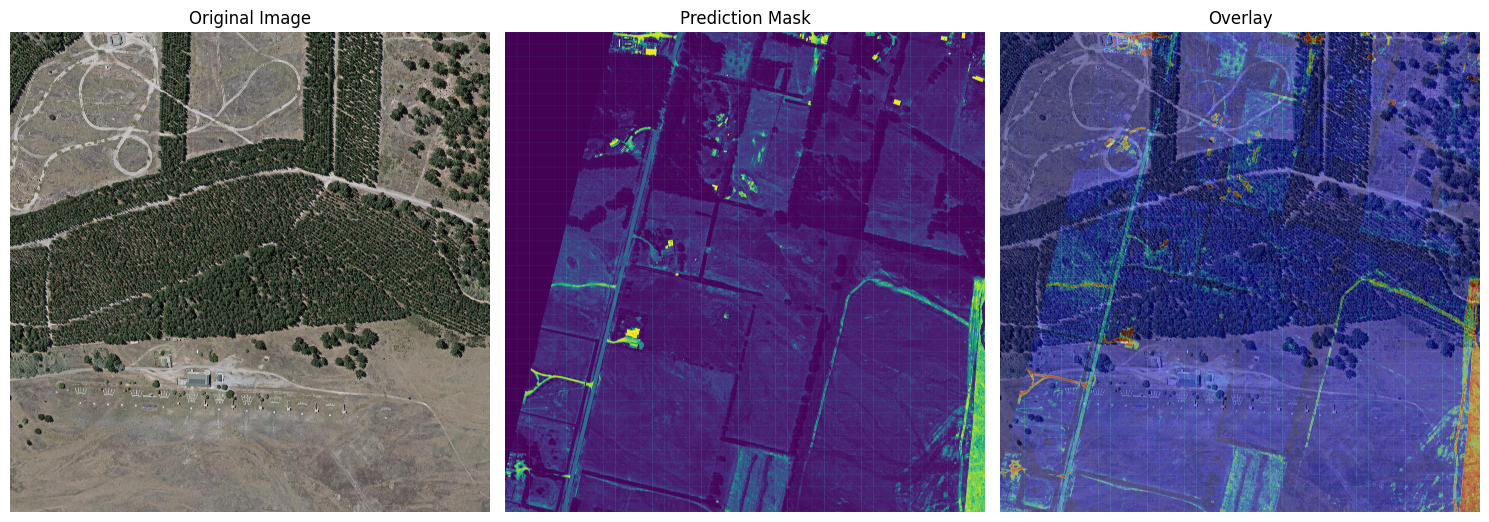

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show

def visualize_prediction(image_path, prediction, figsize=(15, 10)):
    """
    Visualize original image, prediction mask, and overlay side-by-side
    
    Args:
        image_path: Path to original geospatial image
        prediction: Numpy array of predictions (H,W)
        figsize: Figure size (width, height)
    """
    # Open original image
    with rasterio.open(image_path) as src:
        img = src.read()
        
        # Handle single-channel images
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)  # Convert to RGB
        elif img.shape[0] > 3:  # If multiband, take first 3 bands
            img = img[:3]
        
        # Normalize image for display
        img = np.moveaxis(img, 0, -1)  # Change from (C,H,W) to (H,W,C)
        img = (img - img.min()) / (img.max() - img.min())
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    # Original Image
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Prediction Mask
    ax2.imshow(prediction, cmap='viridis')
    ax2.set_title('Prediction Mask')
    ax2.axis('off')
    
    # Overlay
    ax3.imshow(img)
    ax3.imshow(prediction, cmap='jet', alpha=0.4)  # 40% transparency
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
img_id = 30 

# For full image prediction
full_pred = predict_large_image(trained_model, f"data\\train\\image\\christchurch_{img_id}.tif", 
                              patch_size=512, 
                              stride=256,
                              device="cpu")
# Usage Example:
visualize_prediction(f"data\\train\\image\\christchurch_{img_id}.tif", full_pred)

In [ ]:
200/len(os.listdir(os.getcwd() + "\\data\\train\\image")) # Roughly 20% of the data and using a simple model to reduce computation 

0.23337222870478413